In [12]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import datetime
import re
import math
from collections import OrderedDict
import multiprocessing
import random
import itertools
import colorsys
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import IPython.display
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import tensorflow.keras.layers as KL
import tensorflow.keras.utils as KU
from tensorflow.python.eager import context
import tensorflow.keras.models as KM

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/akTwelve/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 979, done.
remote: Total 979 (delta 0), reused 0 (delta 0), pack-reused 979
Receiving objects: 100% (979/979), 111.87 MiB | 12.66 MiB/s, done.
Resolving deltas: 100% (578/578), done.


In [4]:
%cd /content/Mask_RCNN/

/content/Mask_RCNN


In [5]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
#ROOT_DIR = '../../aktwelve_Mask_RCNN'
#assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'
ROOT_DIR = os.path.abspath("/content/Mask_RCNN")
# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils

In [6]:
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [7]:
class CigButtsConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cig_butts"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (cig_butt)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet101'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    DETECTION_MIN_CONFIDENCE = 0.85
config = CigButtsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

In [8]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [9]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('/content/drive/My Drive/cig_dataset/train_anno/train_anno.json', '/content/drive/My Drive/cig_dataset/train/images')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('/content/drive/My Drive/cig_dataset/val_anno/val_anno.json', '/content/drive/My Drive/cig_dataset/val/images')
dataset_val.prepare()
dataset_train.class_names

['BG', 'cig_butt']

In [10]:
from mrcnn import visualize

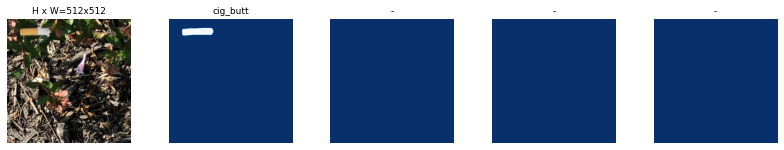

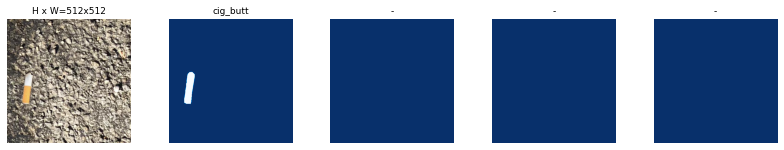

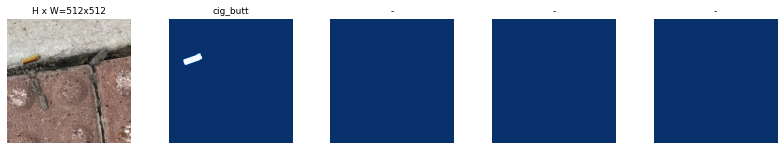

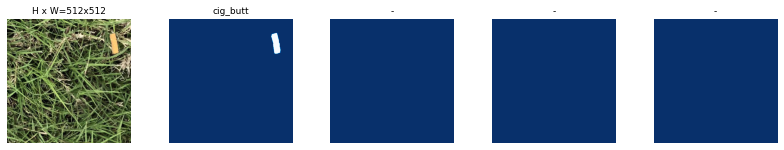

In [11]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [14]:
from mrcnn.model import *

In [15]:
    def get_anchors(image_shape):
        """Returns anchor pyramid for the given image size."""
        backbone_shapes = compute_backbone_shapes(config, image_shape)
        # Cache anchors and reuse if image shape is the same
        #if not hasattr(self, "_anchor_cache"):
        anchor_cache = {}
        #if not tuple(image_shape) in self._anchor_cache:
            # Generate Anchors
        a = utils.generate_pyramid_anchors(
                config.RPN_ANCHOR_SCALES,
                config.RPN_ANCHOR_RATIOS,
                backbone_shapes,
                config.BACKBONE_STRIDES,
                config.RPN_ANCHOR_STRIDE)
            # Keep a copy of the latest anchors in pixel coordinates because
            # it's used in inspect_model notebooks.
            # TODO: Remove this after the notebook are refactored to not use it
        anchors = a
            # Normalize coordinates
        anchor_cache[tuple(image_shape)] = utils.norm_boxes(a, image_shape[:2])
        return anchor_cache[tuple(image_shape)]

In [16]:
    def build(mode, config):
        """Build Mask R-CNN architecture.
            input_shape: The shape of the input image.
            mode: Either "training" or "inference". The inputs and
                outputs of the model differ accordingly.
        """
        assert mode in ['training', 'inference']

        # Image size must be dividable by 2 multiple times
        h, w = config.IMAGE_SHAPE[:2]
        if h / 2**6 != int(h / 2**6) or w / 2**6 != int(w / 2**6):
            raise Exception("Image size must be dividable by 2 at least 6 times "
                            "to avoid fractions when downscaling and upscaling."
                            "For example, use 256, 320, 384, 448, 512, ... etc. ")

        # Inputs
        input_image = KL.Input(
            shape=[None, None, config.IMAGE_SHAPE[2]], name="input_image")
        input_image_meta = KL.Input(shape=[config.IMAGE_META_SIZE],
                                    name="input_image_meta")
        if mode == "training":
            # RPN GT
            input_rpn_match = KL.Input(
                shape=[None, 1], name="input_rpn_match", dtype=tf.int32)
            input_rpn_bbox = KL.Input(
                shape=[None, 4], name="input_rpn_bbox", dtype=tf.float32)

            # Detection GT (class IDs, bounding boxes, and masks)
            # 1. GT Class IDs (zero padded)
            input_gt_class_ids = KL.Input(
                shape=[None], name="input_gt_class_ids", dtype=tf.int32)
            # 2. GT Boxes in pixels (zero padded)
            # [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in image coordinates
            input_gt_boxes = KL.Input(
                shape=[None, 4], name="input_gt_boxes", dtype=tf.float32)
            # Normalize coordinates
            gt_boxes = KL.Lambda(lambda x: norm_boxes_graph(
                x, K.shape(input_image)[1:3]))(input_gt_boxes)
            # 3. GT Masks (zero padded)
            # [batch, height, width, MAX_GT_INSTANCES]
            if config.USE_MINI_MASK:
                input_gt_masks = KL.Input(
                    shape=[config.MINI_MASK_SHAPE[0],
                           config.MINI_MASK_SHAPE[1], None],
                    name="input_gt_masks", dtype=bool)
            else:
                input_gt_masks = KL.Input(
                    shape=[config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], None],
                    name="input_gt_masks", dtype=bool)
        elif mode == "inference":
            # Anchors in normalized coordinates
            input_anchors = KL.Input(shape=[None, 4], name="input_anchors")

        # Build the shared convolutional layers.
        # Bottom-up Layers
        # Returns a list of the last layers of each stage, 5 in total.
        # Don't create the thead (stage 5), so we pick the 4th item in the list.
        if callable(config.BACKBONE):
            _, C2, C3, C4, C5 = config.BACKBONE(input_image, stage5=True,
                                                train_bn=config.TRAIN_BN)
        else:
            _, C2, C3, C4, C5 = resnet_graph(input_image, config.BACKBONE,
                                             stage5=True, train_bn=config.TRAIN_BN)
        # Top-down Layers
        # TODO: add assert to varify feature map sizes match what's in config
        P5 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c5p5')(C5)
        P4 = KL.Add(name="fpn_p4add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p5upsampled")(P5),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c4p4')(C4)])
        P3 = KL.Add(name="fpn_p3add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p4upsampled")(P4),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c3p3')(C3)])
        P2 = KL.Add(name="fpn_p2add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p3upsampled")(P3),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c2p2')(C2)])
        # Attach 3x3 conv to all P layers to get the final feature maps.
        P2 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p2")(P2)
        P3 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p3")(P3)
        P4 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p4")(P4)
        P5 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p5")(P5)
        # P6 is used for the 5th anchor scale in RPN. Generated by
        # subsampling from P5 with stride of 2.
        P6 = KL.MaxPooling2D(pool_size=(1, 1), strides=2, name="fpn_p6")(P5)

        # Note that P6 is used in RPN, but not in the classifier heads.
        rpn_feature_maps = [P2, P3, P4, P5, P6]
        mrcnn_feature_maps = [P2, P3, P4, P5]

        # Anchors
        if mode == "training":
            anchors = get_anchors(config.IMAGE_SHAPE)
            # Duplicate across the batch dimension because Keras requires it
            # TODO: can this be optimized to avoid duplicating the anchors?
            anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)
            # A hack to get around Keras's bad support for constants
            # This class returns a constant layer
            class ConstLayer(tf.keras.layers.Layer):
                def __init__(self, x, name=None):
                    super(ConstLayer, self).__init__(name=name)
                    self.x = tf.Variable(x)

                def call(self, input):
                    return self.x

            anchors = ConstLayer(anchors, name="anchors")(input_image)
        else:
            anchors = input_anchors

        # RPN Model
        rpn = build_rpn_model(config.RPN_ANCHOR_STRIDE,
                              len(config.RPN_ANCHOR_RATIOS), config.TOP_DOWN_PYRAMID_SIZE)
        # Loop through pyramid layers
        layer_outputs = []  # list of lists
        for p in rpn_feature_maps:
            layer_outputs.append(rpn([p]))
        # Concatenate layer outputs
        # Convert from list of lists of level outputs to list of lists
        # of outputs across levels.
        # e.g. [[a1, b1, c1], [a2, b2, c2]] => [[a1, a2], [b1, b2], [c1, c2]]
        output_names = ["rpn_class_logits", "rpn_class", "rpn_bbox"]
        outputs = list(zip(*layer_outputs))
        outputs = [KL.Concatenate(axis=1, name=n)(list(o))
                   for o, n in zip(outputs, output_names)]

        rpn_class_logits, rpn_class, rpn_bbox = outputs

        # Generate proposals
        # Proposals are [batch, N, (y1, x1, y2, x2)] in normalized coordinates
        # and zero padded.
        proposal_count = config.POST_NMS_ROIS_TRAINING if mode == "training"\
            else config.POST_NMS_ROIS_INFERENCE
        rpn_rois = ProposalLayer(
            proposal_count=proposal_count,
            nms_threshold=config.RPN_NMS_THRESHOLD,
            name="ROI",
            config=config)([rpn_class, rpn_bbox, anchors])

        if mode == "training":
            # Class ID mask to mark class IDs supported by the dataset the image
            # came from.
            active_class_ids = KL.Lambda(
                lambda x: parse_image_meta_graph(x)["active_class_ids"]
                )(input_image_meta)

            if not config.USE_RPN_ROIS:
                # Ignore predicted ROIs and use ROIs provided as an input.
                input_rois = KL.Input(shape=[config.POST_NMS_ROIS_TRAINING, 4],
                                      name="input_roi", dtype=np.int32)
                # Normalize coordinates
                target_rois = KL.Lambda(lambda x: norm_boxes_graph(
                    x, K.shape(input_image)[1:3]))(input_rois)
            else:
                target_rois = rpn_rois

            # Generate detection targets
            # Subsamples proposals and generates target outputs for training
            # Note that proposal class IDs, gt_boxes, and gt_masks are zero
            # padded. Equally, returned rois and targets are zero padded.
            rois, target_class_ids, target_bbox, target_mask =\
                DetectionTargetLayer(config, name="proposal_targets")([
                    target_rois, input_gt_class_ids, gt_boxes, input_gt_masks])

            # Network Heads
            # TODO: verify that this handles zero padded ROIs
            mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
                fpn_classifier_graph(rois, mrcnn_feature_maps, input_image_meta,
                                     config.POOL_SIZE, config.NUM_CLASSES,
                                     train_bn=config.TRAIN_BN,
                                     fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

            mrcnn_mask = build_fpn_mask_graph(rois, mrcnn_feature_maps,
                                              input_image_meta,
                                              config.MASK_POOL_SIZE,
                                              config.NUM_CLASSES,
                                              train_bn=config.TRAIN_BN)

            # TODO: clean up (use tf.identify if necessary)
            output_rois = KL.Lambda(lambda x: x * 1, name="output_rois")(rois)

            # Losses
            rpn_class_loss = KL.Lambda(lambda x: rpn_class_loss_graph(*x), name="rpn_class_loss")(
                [input_rpn_match, rpn_class_logits])
            rpn_bbox_loss = KL.Lambda(lambda x: rpn_bbox_loss_graph(config, *x), name="rpn_bbox_loss")(
                [input_rpn_bbox, input_rpn_match, rpn_bbox])
            class_loss = KL.Lambda(lambda x: mrcnn_class_loss_graph(*x), name="mrcnn_class_loss")(
                [target_class_ids, mrcnn_class_logits, active_class_ids])
            bbox_loss = KL.Lambda(lambda x: mrcnn_bbox_loss_graph(*x), name="mrcnn_bbox_loss")(
                [target_bbox, target_class_ids, mrcnn_bbox])
            mask_loss = KL.Lambda(lambda x: mrcnn_mask_loss_graph(*x), name="mrcnn_mask_loss")(
                [target_mask, target_class_ids, mrcnn_mask])

            # Model
            inputs = [input_image, input_image_meta,
                      input_rpn_match, input_rpn_bbox, input_gt_class_ids, input_gt_boxes, input_gt_masks]
            if not config.USE_RPN_ROIS:
                inputs.append(input_rois)
            outputs = [rpn_class_logits, rpn_class, rpn_bbox,
                       mrcnn_class_logits, mrcnn_class, mrcnn_bbox, mrcnn_mask,
                       rpn_rois, output_rois,
                       rpn_class_loss, rpn_bbox_loss, class_loss, bbox_loss, mask_loss]
            model = KM.Model(inputs, outputs, name='mask_rcnn')
        else:
            # Network Heads
            # Proposal classifier and BBox regressor heads
            mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
                fpn_classifier_graph(rpn_rois, mrcnn_feature_maps, input_image_meta,
                                     config.POOL_SIZE, config.NUM_CLASSES,
                                     train_bn=config.TRAIN_BN,
                                     fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

            # Detections
            # output is [batch, num_detections, (y1, x1, y2, x2, class_id, score)] in
            # normalized coordinates
            detections = DetectionLayer(config, name="mrcnn_detection")(
                [rpn_rois, mrcnn_class, mrcnn_bbox, input_image_meta])

            # Create masks for detections
            detection_boxes = KL.Lambda(lambda x: x[..., :4])(detections)
            mrcnn_mask = build_fpn_mask_graph(detection_boxes, mrcnn_feature_maps,
                                              input_image_meta,
                                              config.MASK_POOL_SIZE,
                                              config.NUM_CLASSES,
                                              train_bn=config.TRAIN_BN)

            model = KM.Model([input_image, input_image_meta, input_anchors],
                             [detections, mrcnn_class, mrcnn_bbox,
                                 mrcnn_mask, rpn_rois, rpn_class, rpn_bbox],
                             name='mask_rcnn')

        # Add multi-GPU support.
        if config.GPU_COUNT > 1:
            from mrcnn.parallel_model import ParallelModel
            model = ParallelModel(model, config.GPU_COUNT)

        return model


In [17]:
model = build(mode='training', config=config)
model.summary()
print(type(model))

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

In [18]:
# Which weights to start with?
#init_with = "coco"  # imagenet, coco, or last

#if init_with == "imagenet":
    #model.load_weights(model.get_imagenet_weights(), by_name=True)
#elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
model.load_weights(COCO_MODEL_PATH, by_name=True, skip_mismatch=True)
                       #exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                #"mrcnn_bbox", "mrcnn_mask"])
#elif init_with == "last":
    # Load the last model you trained and continue training
    #model.load_weights(model.find_last(), by_name=True)

In [19]:
import tensorflow as tf
learning_rate = 1e-4
momentum = 0.9
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, clipnorm=config.GRADIENT_CLIP_NORM)
loss_names = ["rpn_class_loss",  "rpn_bbox_loss",
            "mrcnn_class_loss", "mrcnn_bbox_loss", "mrcnn_mask_loss"]

for name in loss_names:
  layer = model.get_layer(name)
  #if layer.output in model.losses:
      #continue
  loss = (tf.reduce_mean(input_tensor=layer.output, keepdims=True)* config.LOSS_WEIGHTS.get(name, 1.))
  model.add_loss(loss) 

reg_losses = [tf.keras.regularizers.l2(config.WEIGHT_DECAY)(w) / tf.cast(tf.size(input=w), tf.float32)
            for w in model.trainable_weights
            if 'gamma' not in w.name and 'beta' not in w.name]
model.add_loss(tf.add_n(reg_losses))         
print("loss added")
model.compile(optimizer=optimizer, loss=[None] * len(model.outputs))
print('model compiled')
for name in loss_names:
  #if name in model.metrics_names:
    #continue
  layer = model.get_layer(name)
  model.metrics_names.append(name)
  loss = (tf.reduce_mean(input_tensor=layer.output, keepdims=True) * config.LOSS_WEIGHTS.get(name, 1.))
  model.add_metric(loss, name=name, aggregation='mean')

print('metrics added')

[<tf.Variable 'conv1/kernel:0' shape=(7, 7, 3, 64) dtype=float32>, <tf.Variable 'conv1/bias:0' shape=(64,) dtype=float32>, <tf.Variable 'bn_conv1/gamma:0' shape=(64,) dtype=float32>, <tf.Variable 'bn_conv1/beta:0' shape=(64,) dtype=float32>, <tf.Variable 'res2a_branch2a/kernel:0' shape=(1, 1, 64, 64) dtype=float32>, <tf.Variable 'res2a_branch2a/bias:0' shape=(64,) dtype=float32>, <tf.Variable 'bn2a_branch2a/gamma:0' shape=(64,) dtype=float32>, <tf.Variable 'bn2a_branch2a/beta:0' shape=(64,) dtype=float32>, <tf.Variable 'res2a_branch2b/kernel:0' shape=(3, 3, 64, 64) dtype=float32>, <tf.Variable 'res2a_branch2b/bias:0' shape=(64,) dtype=float32>, <tf.Variable 'bn2a_branch2b/gamma:0' shape=(64,) dtype=float32>, <tf.Variable 'bn2a_branch2b/beta:0' shape=(64,) dtype=float32>, <tf.Variable 'res2a_branch2c/kernel:0' shape=(1, 1, 64, 256) dtype=float32>, <tf.Variable 'res2a_branch2c/bias:0' shape=(256,) dtype=float32>, <tf.Variable 'res2a_branch1/kernel:0' shape=(1, 1, 64, 256) dtype=float32>,

In [20]:
from mrcnn.model import DataGenerator

In [21]:
# Data generators
train_generator = DataGenerator(dataset_train, config, shuffle=True)
                                         
val_generator = DataGenerator(dataset_val, config, shuffle=True)

In [22]:
model.fit(train_generator, validation_data=val_generator, epochs=4, steps_per_epoch=500)

Epoch 1/4


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 1.0708 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.6526 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.2339 - mrcnn_mask_loss: 0.1332WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
500/500 [==============================] - 367s 733ms/step - batch: 249.5000 - size: 1.0000 - loss: 1.0708 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.6526 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.2339 - mrcnn_mask_loss: 0.1332 - val_loss: 0.5889 - val_rpn_class_loss: 0.0047 - val_rpn_bbox_loss: 0.3124 - val_mrcnn_class_loss: 0.0405 - val_mrcnn_bbox_loss: 0.1265 - val_mrcnn_mask_loss: 0.1048
Epoch 2/4
500/500 

KeyboardInterrupt: ignored

In [23]:
model.save_weights('/content/sample_data/model.h5', overwrite=True)

In [24]:
model_pred = build(mode='inference', config=config)

Instructions for updating:
Use fn_output_signature instead


In [25]:
model_pred.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

In [26]:
model_pred.load_weights('/content/sample_data/model.h5', by_name=True, skip_mismatch=True)

In [27]:
def mold_inputs(images):
  """Takes a list of images and modifies them to the format expected
  as an input to the neural network.
  images: List of image matrices [height,width,depth]. Images can have
  different sizes.
  Returns 3 Numpy matrices:
  molded_images: [N, h, w, 3]. Images resized and normalized.
  image_metas: [N, length of meta data]. Details about each image.
  windows: [N, (y1, x1, y2, x2)]. The portion of the image that has the
  original image (padding excluded).
  """
  molded_images = []
  image_metas = []
  windows = []
  for image in images:
    # Resize image
    # TODO: move resizing to mold_image()
    molded_image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)
    molded_image = mold_image(molded_image, config)
    # Build image_meta
    image_meta = compose_image_meta(
                0, image.shape, molded_image.shape, window, scale,
                np.zeros([config.NUM_CLASSES], dtype=np.int32))
    # Append
    molded_images.append(molded_image)
    windows.append(window)
    image_metas.append(image_meta)
    # Pack into arrays
    molded_images = np.stack(molded_images)
    image_metas = np.stack(image_metas)
    windows = np.stack(windows)
    return molded_images, image_metas, windows

def unmold_detections(detections, mrcnn_mask, original_image_shape,
                          image_shape, window):
  """Reformats the detections of one image from the format of the neural
  network output to a format suitable for use in the rest of the
  application.
  detections: [N, (y1, x1, y2, x2, class_id, score)] in normalized coordinates
  mrcnn_mask: [N, height, width, num_classes]
  original_image_shape: [H, W, C] Original image shape before resizing
  image_shape: [H, W, C] Shape of the image after resizing and padding
  window: [y1, x1, y2, x2] Pixel coordinates of box in the image where the real
  image is excluding the padding.
  Returns:
  boxes: [N, (y1, x1, y2, x2)] Bounding boxes in pixels
  class_ids: [N] Integer class IDs for each bounding box
  scores: [N] Float probability scores of the class_id
  masks: [height, width, num_instances] Instance masks
  """
  # How many detections do we have?
  # Detections array is padded with zeros. Find the first class_id == 0.
  zero_ix = np.where(detections[:, 4] == 0)[0]
  N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]

  # Extract boxes, class_ids, scores, and class-specific masks
  boxes = detections[:N, :4]
  class_ids = detections[:N, 4].astype(np.int32)
  scores = detections[:N, 5]
  masks = mrcnn_mask[np.arange(N), :, :, class_ids]

  # Translate normalized coordinates in the resized image to pixel
  # coordinates in the original image before resizing
  window = utils.norm_boxes(window, image_shape[:2])
  wy1, wx1, wy2, wx2 = window
  shift = np.array([wy1, wx1, wy1, wx1])
  wh = wy2 - wy1  # window height
  ww = wx2 - wx1  # window width
  scale = np.array([wh, ww, wh, ww])
  # Convert boxes to normalized coordinates on the window
  boxes = np.divide(boxes - shift, scale)
  # Convert boxes to pixel coordinates on the original image
  boxes = utils.denorm_boxes(boxes, original_image_shape[:2])

  # Filter out detections with zero area. Happens in early training when
  # network weights are still random
  exclude_ix = np.where(
            (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]
  if exclude_ix.shape[0] > 0:
    boxes = np.delete(boxes, exclude_ix, axis=0)
    class_ids = np.delete(class_ids, exclude_ix, axis=0)
    scores = np.delete(scores, exclude_ix, axis=0)
    masks = np.delete(masks, exclude_ix, axis=0)
    N = class_ids.shape[0]

  # Resize masks to original image size and set boundary threshold.
  full_masks = []
  for i in range(N):
  # Convert neural network mask to full size mask
    full_mask = utils.unmold_mask(masks[i], boxes[i], original_image_shape)
    full_masks.append(full_mask)
  full_masks = np.stack(full_masks, axis=-1)\
        if full_masks else np.empty(original_image_shape[:2] + (0,))

  return boxes, class_ids, scores, full_masks

In [28]:
dataset_train.class_names

['BG', 'cig_butt']

In [30]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

In [32]:
def annotate_image(image_path, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    img = tf.keras.preprocessing.image.load_img(image_path)
    image = np.array(img)
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()

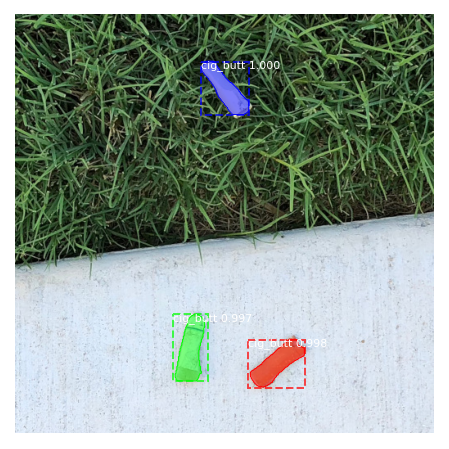

In [38]:
import cv2
img_path = '/content/test/0005.JPG'
image = tf.keras.preprocessing.image.load_img(path=img_path)
img_array = np.array(image)
image = cv2.resize(img_array, (512,512))
molded_images, image_metas, windows = mold_inputs([img_array])
image_shape = molded_images[0].shape
for g in molded_images[1:]:
  assert g.shape == image_shape 
"After resizing, all images must have the same size. Check IMAGE_RESIZE_MODE and image sizes"
anchors = get_anchors(image_shape)
anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)
detections, _, _, mrcnn_mask, _, _, _ = model_pred.predict([molded_images, image_metas, anchors], verbose=0)
results=[]
for i, image in enumerate([img_array]):
  final_rois, final_class_ids, final_scores, final_masks = unmold_detections(detections[i], mrcnn_mask[i],
                                       image.shape, molded_images[i].shape,
                                       windows[i])

results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
                  })
r = results[0]
annotate_image(img_path, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], figsize=(8,8))
#visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], figsize=(5,5))


(1, 65472, 4)


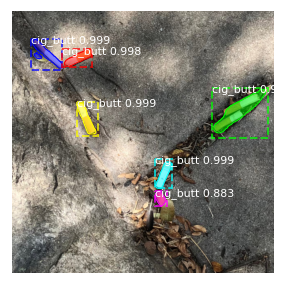

(1, 65472, 4)


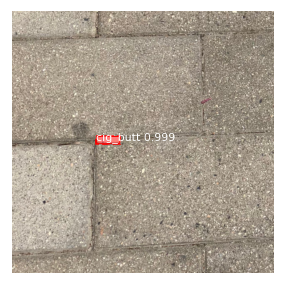

(1, 65472, 4)


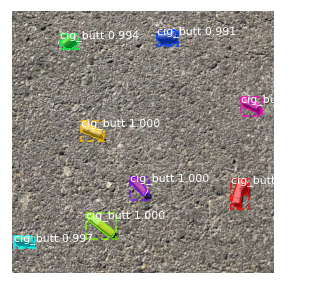

(1, 65472, 4)


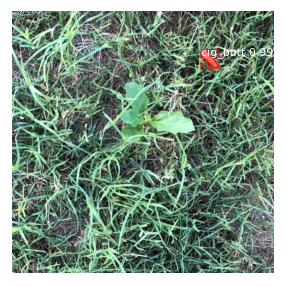

(1, 65472, 4)


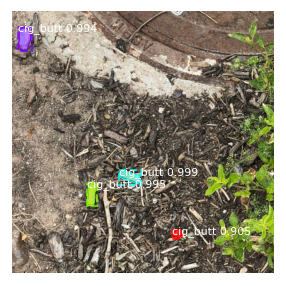

(1, 65472, 4)


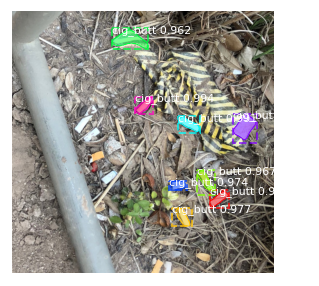

(1, 65472, 4)


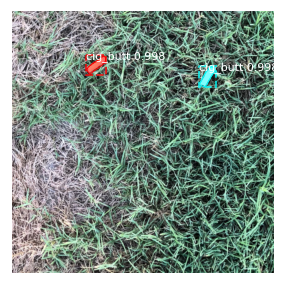

(1, 65472, 4)


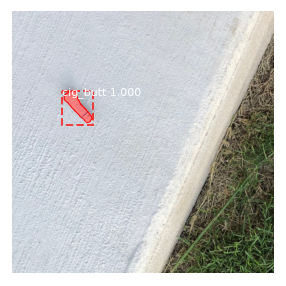

(1, 65472, 4)


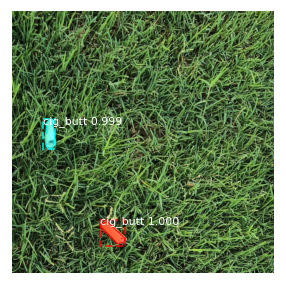

(1, 65472, 4)


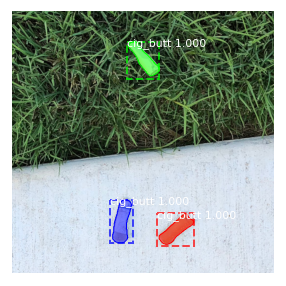

In [ ]:
import skimage
real_test_dir = '/content/test'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    molded_images, image_metas, windows = mold_inputs([img_arr])
    image_shape = molded_images[0].shape
    for g in molded_images[1:]:
      assert g.shape == image_shape,\
"After resizing, all images must have the same size. Check IMAGE_RESIZE_MODE and image sizes."
    anchors = get_anchors(image_shape)
# Duplicate across the batch dimension because Keras requires it
# TODO: can this be optimized to avoid duplicating the anchors?
    anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)
    detections, _, _, mrcnn_mask, _, _, _ =\
            model_pred.predict([molded_images, image_metas, anchors], verbose=0)
    #results = model.detect([img_arr], verbose=1)
    results = []
    for i, image in enumerate([img_arr]):
      final_rois, final_class_ids, final_scores, final_masks = unmold_detections(detections[i], mrcnn_mask[i],
                                       image.shape, molded_images[i].shape,
                                       windows[i])
      results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
                  })
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], figsize=(5,5))


